## Demo for Loading and Combining TDC Data 

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.TDI import *


# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

### Load data to directionary 
All the TDC data can be loaded as dictionaries, each containing 3 items: 
- ``eta``: the single-link measurements $\eta_{ij}$ (intermediate variable of TDI processing), which is a dictionary with keys "12", "23", "31", "21", "32", "13"; 
- ``time``: the time of data; 
- ``parameters``: the parameters of GW sources. 

The default unit of data is fractional frequency difference (dimensionless).

In [29]:
# h5filename should be the path of TDC data
# h5filename = "/Volumes/RubbishBin/TDC2_GWData/5_h5datasets/singlesource_dataset_mbhb_30dayfrom40day.h5"
h5filename = "/Volumes/RubbishBin/TDC2_GWData/5_h5datasets/globalfit_dataset_mbhb_gb_sgwb.h5"
with h5py.File(h5filename, "r") as h5file: 
    data_dict = read_dict_from_h5(h5file["/"])
data_dict

{'eta': {'12': array([ 8.66203454e-23,  3.41117073e-23, -2.06344760e-23, ...,
          2.18163716e-22,  1.79792551e-22,  1.35585378e-22]),
  '13': array([3.00511578e-22, 3.51910628e-22, 4.01201175e-22, ...,
         1.45944712e-22, 1.96287830e-22, 2.48220935e-22]),
  '21': array([1.85579609e-22, 1.50622352e-22, 1.08651919e-22, ...,
         2.41495590e-22, 2.31405309e-22, 2.12689123e-22]),
  '23': array([-6.70468136e-22, -7.19676234e-22, -7.64832520e-22, ...,
         -5.09269207e-22, -5.64106909e-22, -6.18235082e-22]),
  '31': array([ 1.45707050e-24,  4.53976716e-23,  9.47777008e-23, ...,
         -8.96922211e-23, -6.66100943e-23, -3.61027643e-23]),
  '32': array([-6.64127852e-22, -7.18033691e-22, -7.68529741e-22, ...,
         -4.93517515e-22, -5.50672936e-22, -6.07943807e-22])},
 'parameters': {'gb': b'TDC2_DWD_Catalog.npy',
  'mbhb': {'chirp_mass': array([ 592032.43781665,  543286.76620088, 1248240.94197974,
           801601.5591622 ,  454015.11720918, 2447960.51610457,
         

### Visualize raw data 
The single-link measurements are dominated by laser frequency noises, which needs to be suppressed by the subsequent TDI processing. 

Text(0, 0.5, '$\\eta_{12}$')

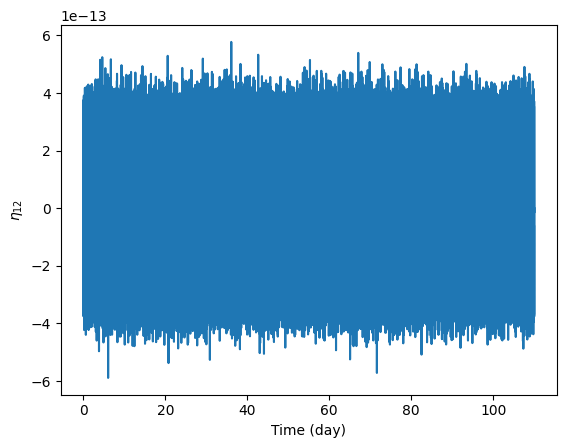

In [30]:
plt.plot(data_dict["time"] / DAY, data_dict["eta"]["12"])
plt.xlabel("Time (day)")
plt.ylabel(r"$\eta_{12}$")

Text(0, 0.5, '$\\tilde{\\eta}_{12}$')

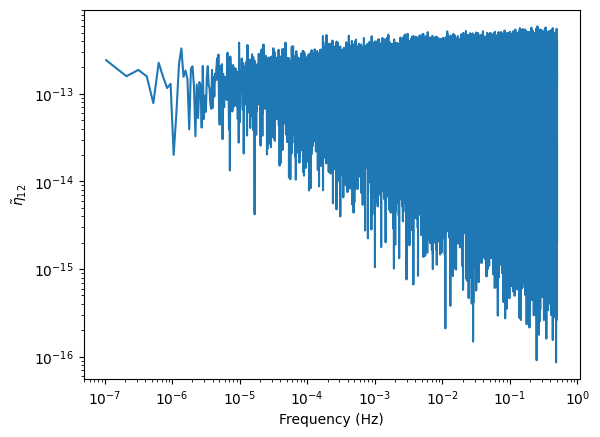

In [31]:
fsample = 1. / (data_dict["time"][1] - data_dict["time"][0])
ff, xf = PSD_window(data_dict["eta"]["12"], fsample=fsample, nbin=1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{\eta}_{12}$")

### TDI combination 
To explore the impacts and effects of various TDI schemes in GW data analysis, all the TDC data are provided in terms of single-link measurement $\eta_{ij}$.
Since we start from $\eta_{ij}$, the first 2 steps of TDI (raw data $\rightarrow \xi_{ij}, \xi_{ij} \rightarrow \eta_{ij}$) are unnecessary.
The users only need to combine their custom TDI channels according to the methods outlined in Demo 1 and Demo 2. 
In this demo, we employ the ``FastMichelson`` method as an example.

In [32]:
# calculate the light travel times, which will be used as the delays
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB')
ltts = dict() 
for key in MOSA_labels: 
    ltts[key] = orbit.LTTfunctions()[key](data_dict["time"])
ltts = MOSADict(ltts)

# prepare the input data 
m = {"eta" : data_dict["eta"]}

# initical TDI object. We recommand a high interpolation order of 31 to effectively suppress laser frequency noise
tdi = TDI(measurements=m, delays=ltts, fsample=fsample, order=31) 

# TDI combination 
tdi.FastMichelson(channel="X")

### Visualize TDI data 

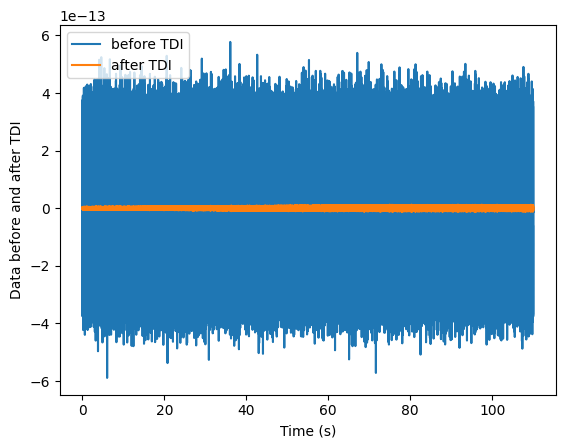

In [33]:
plt.plot(data_dict["time"] / DAY, data_dict["eta"]["12"], label="before TDI")
plt.plot(data_dict["time"][1500:-1500] / DAY, tdi.measurements["X2"][1500:-1500], label="after TDI") # we drop 1500 seconds at the edges 
plt.xlabel("Time (s)")
plt.ylabel("Data before and after TDI")
plt.legend(loc="upper left")

When plotted in the frequency domain, it is evident that a MBHB signal exceeds the noise floor in the mHz to 10mHz band. To clearly show the waveform in the time domain, a further downsampling process (e.g. fsample = 1 Hz to fsample = 0.1 Hz) is required.

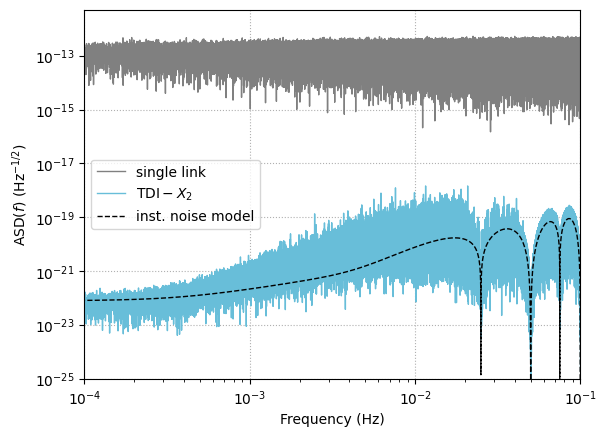

In [34]:
ff, xf = PSD_window(data_dict["eta"]["12"], fsample, 1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf), color="grey", linewidth=1, label="single link")

ff, xf = PSD_window(tdi.measurements["X2"][1500:-1500], fsample, 1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf), color=BLUE, linewidth=1, label=r"${\rm TDI-}X_2$")

PSD = TDIPSDs()
plt.loglog(ff, np.sqrt(PSD.PSD_X2(ff)), color="k", linewidth=1, linestyle="--", label="inst. noise model")

plt.xlim(1e-4, 0.1)
plt.ylim(1e-25, )
plt.grid(linestyle=":")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD}(f) \ ({\rm Hz^{-1/2}})$")
plt.legend(loc="center left")

Text(0, 0.5, 'TDI-X2')

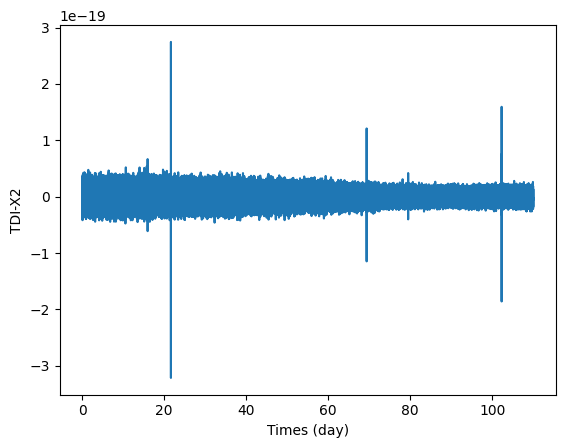

In [35]:
x2_ds = downsampling(tdi.measurements["X2"][1500:-1500], fsample, 10, [240, 0.02, 0.08])[100:-100]
time_ds = ((data_dict["time"][1500:-1500])[::10])[100:-100]
plt.plot(time_ds / DAY, x2_ds)
plt.xlabel("Times (day)")
plt.ylabel("TDI-X2")